## 2. The LASSO and Boosting for Regression

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor

### (a) Download the Communities and Crime data3 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

In [ ]:
file_path = '../data/communities.data'

data2 = pd.read_csv(file_path, header=None)

train_set = data.iloc[:1495, :] 
test_set = data.iloc[1495:, :]   

data2

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


### (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [ ]:
non_predictive_features = [0, 1, 2, 3, 4] 

data_predictive = data2.drop(columns=non_predictive_features)

data_predictive = data_predictive.replace('?', pd.NA)

data_predictive = data_predictive.apply(pd.to_numeric)

train_set = data_predictive.iloc[:1495, :]
test_set = data_predictive.iloc[1495:, :]

print("Training Set Shape:", train_set.shape)
print("Testing Set Shape:", test_set.shape)

Training Set Shape: (1495, 123)
Testing Set Shape: (499, 123)


In [ ]:
imputer = SimpleImputer(strategy='mean')  

train_set_imputed = pd.DataFrame(imputer.fit_transform(train_set), columns=train_set.columns)
test_set_imputed = pd.DataFrame(imputer.transform(test_set), columns=test_set.columns)

print("Training Set Shape (after imputation):", train_set_imputed.shape)
print("Test Set Shape (after imputation):", test_set_imputed.shape)
print("\nSample Training Data After Imputation:")
print(train_set_imputed.head())
print("\nSample Test Data After Imputation:")
print(test_set_imputed.head())

Training Set Shape (after imputation): (1495, 123)
Test Set Shape (after imputation): (499, 123)

Sample Training Data After Imputation:
    5     6     7     8     9     10    11    12    13    14   ...   118  \
0  0.19  0.33  0.02  0.90  0.12  0.17  0.34  0.47  0.29  0.32  ...  0.12   
1  0.00  0.16  0.12  0.74  0.45  0.07  0.26  0.59  0.35  0.27  ...  0.02   
2  0.00  0.42  0.49  0.56  0.17  0.04  0.39  0.47  0.28  0.32  ...  0.01   
3  0.04  0.77  1.00  0.08  0.12  0.10  0.51  0.50  0.34  0.21  ...  0.02   
4  0.01  0.55  0.02  0.95  0.09  0.05  0.38  0.38  0.23  0.36  ...  0.04   

    119   120       121       122       123       124   125       126   127  
0  0.26  0.20  0.060000  0.040000  0.900000  0.500000  0.32  0.140000  0.20  
1  0.12  0.45  0.163975  0.080502  0.713054  0.451883  0.00  0.190753  0.67  
2  0.21  0.02  0.163975  0.080502  0.713054  0.451883  0.00  0.190753  0.43  
3  0.39  0.28  0.163975  0.080502  0.713054  0.451883  0.00  0.190753  0.12  
4  0.09  0.02  0

### (c) Plot a correlation matrix for the features in the data set.

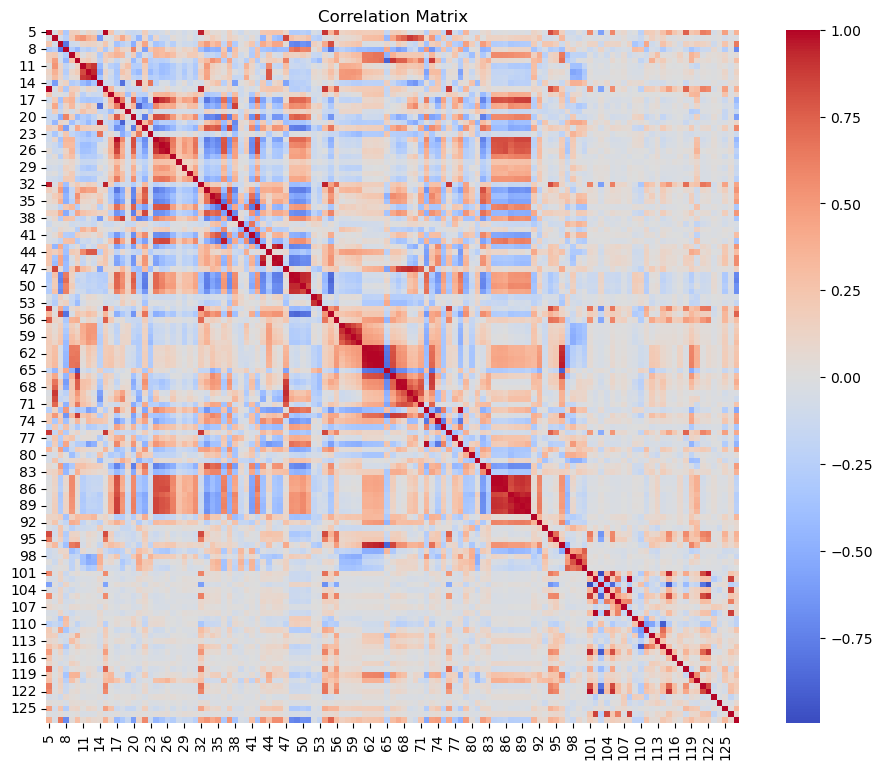

In [ ]:
train_df = pd.DataFrame(train_set_imputed)
plt.figure(figsize=(12, 9))
sns.heatmap(train_df.corr(), cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

### (d) Calculate the Coeﬃcient of Variation CV for each feature, where CV=s/m , in which s is sample standard deviation and m is sample mean..

In [ ]:
means = data_predictive.mean()
stddevs = data_predictive.std()

cv = stddevs / means
print("Coefficient of Variation (CV) for each feature:")
cv

Coefficient of Variation (CV) for each feature:


5      2.203503
6      0.353298
7      1.410920
8      0.323782
9      1.359162
         ...   
123    0.306251
124    0.921372
125    2.555266
126    0.844368
127    0.979015
Length: 123, dtype: float64

### (e) Pick ⌊√128⌋ features with highest CV, and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

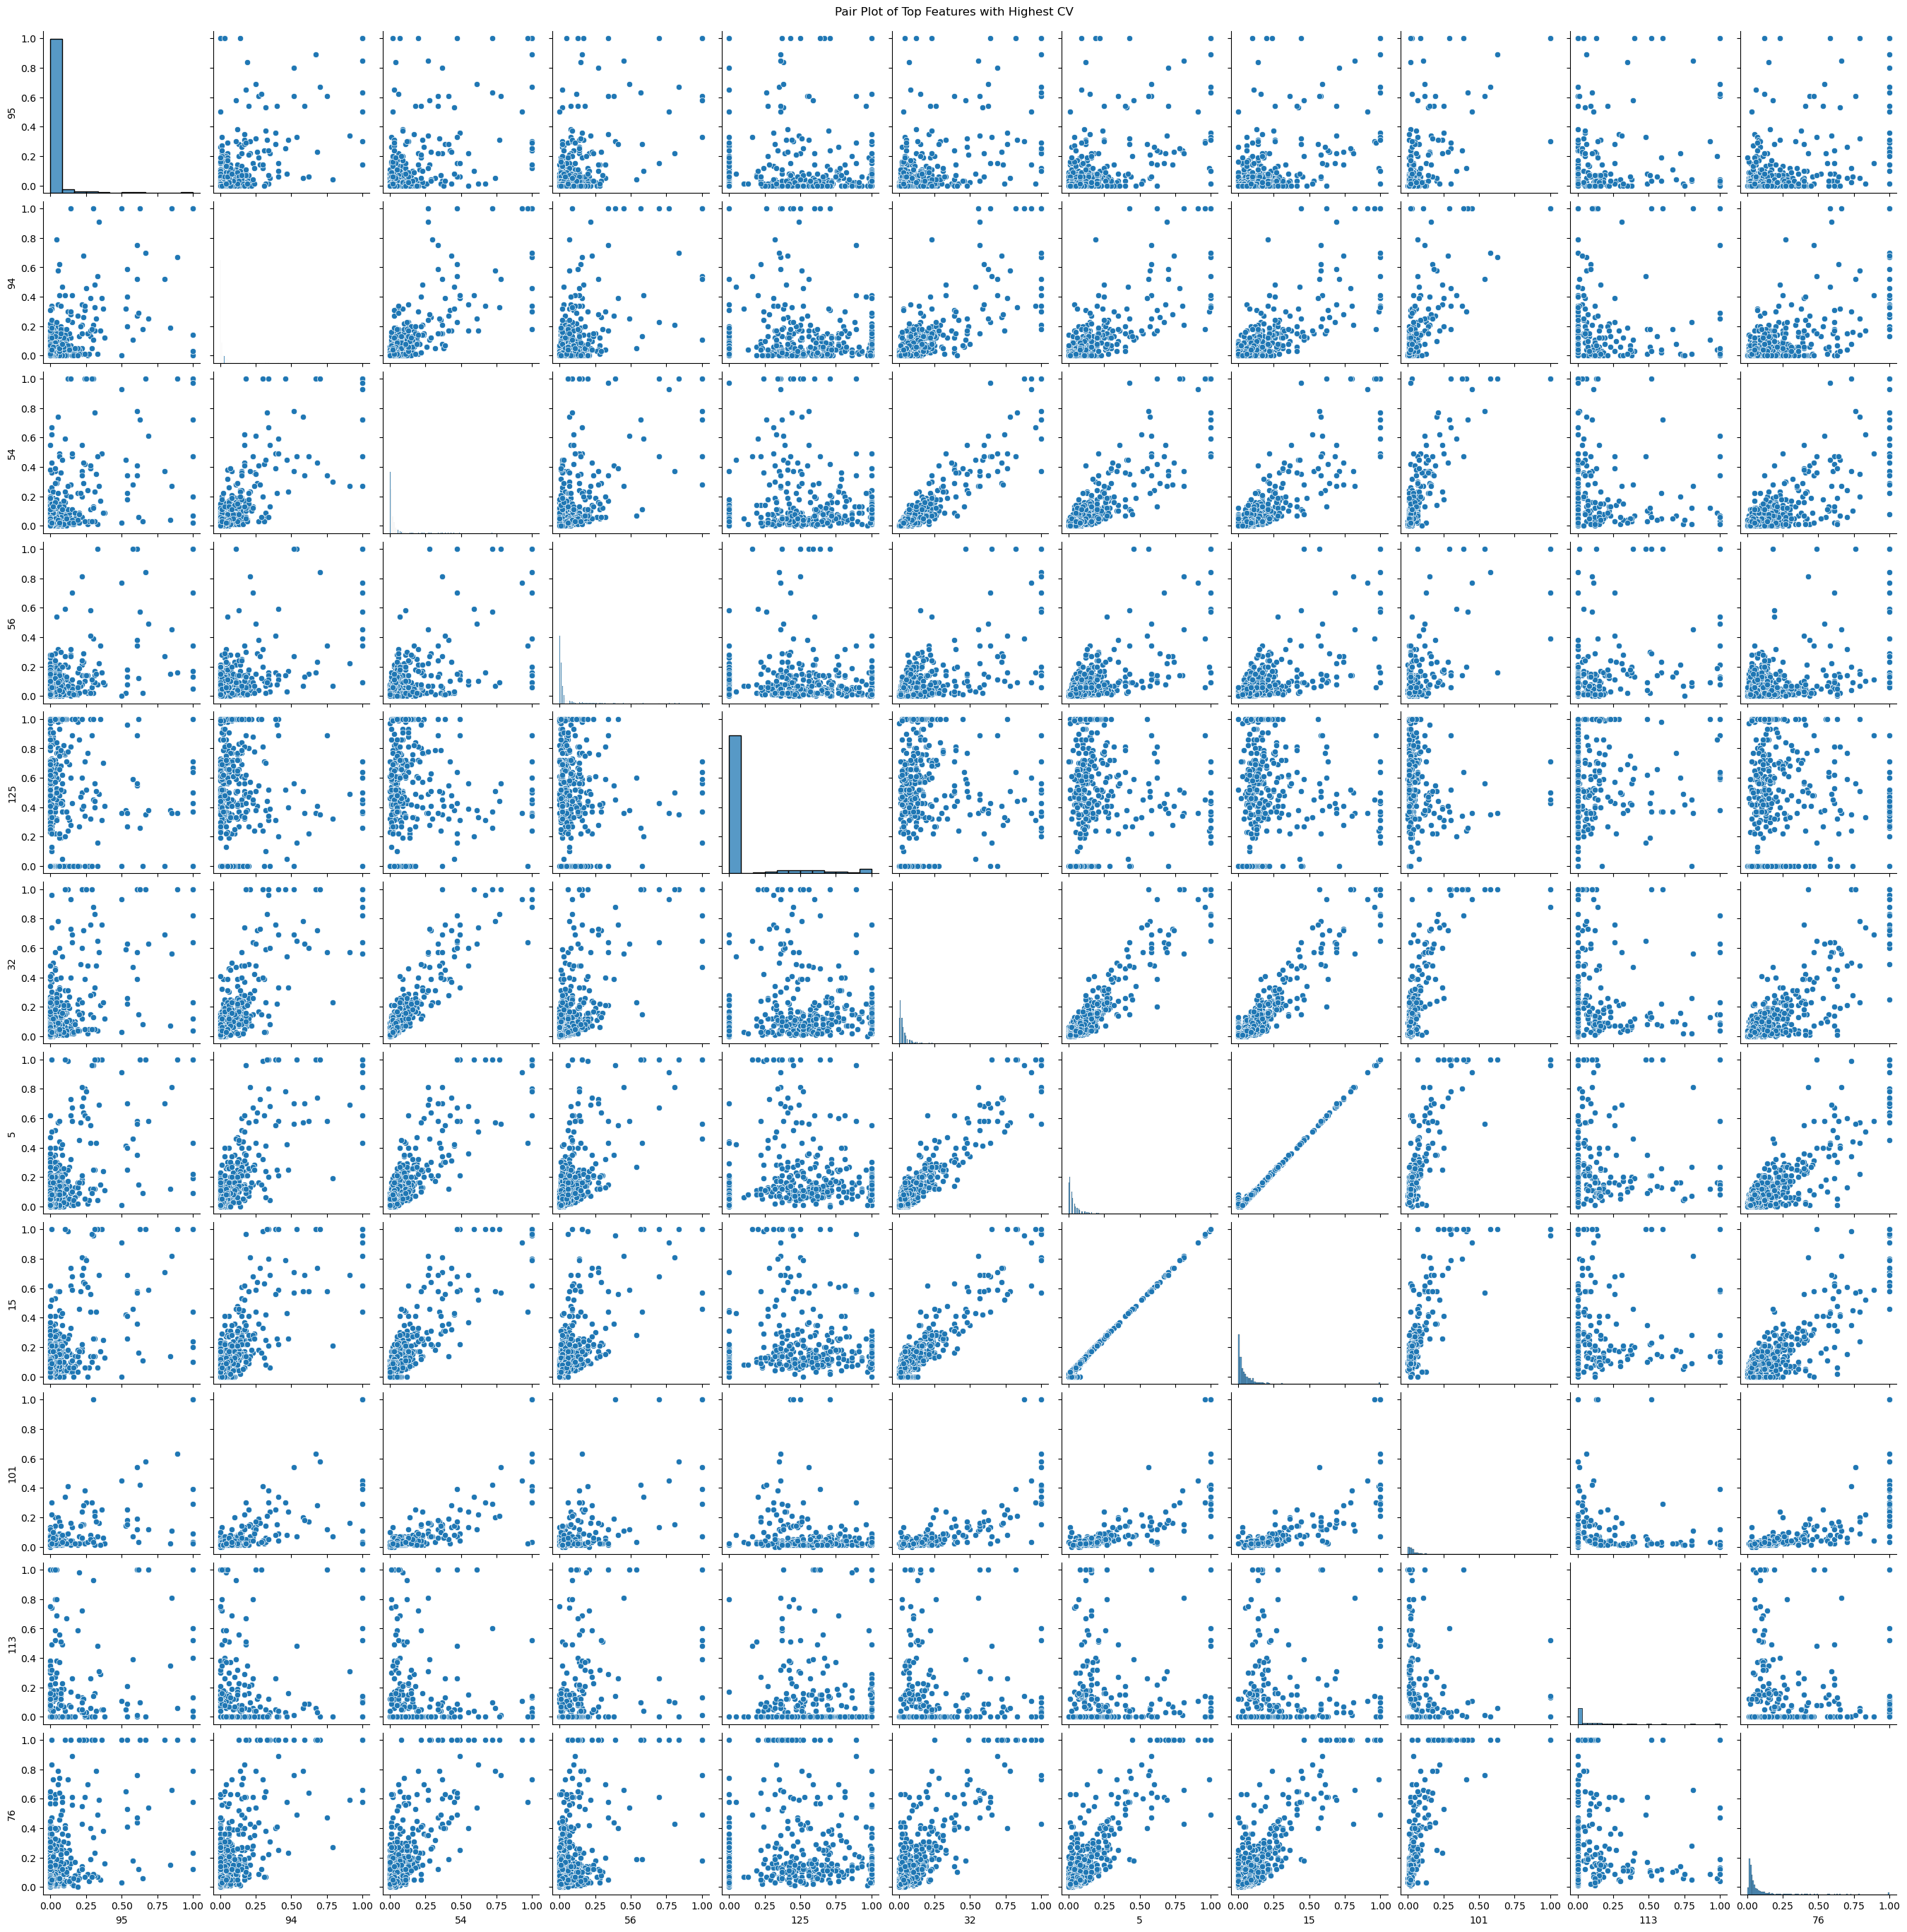

In [ ]:
top_features = cv.nlargest(11).index

sns.pairplot(data_predictive[top_features])
plt.suptitle("Pair Plot of Top Features with Highest CV", y=1.00)
plt.show()

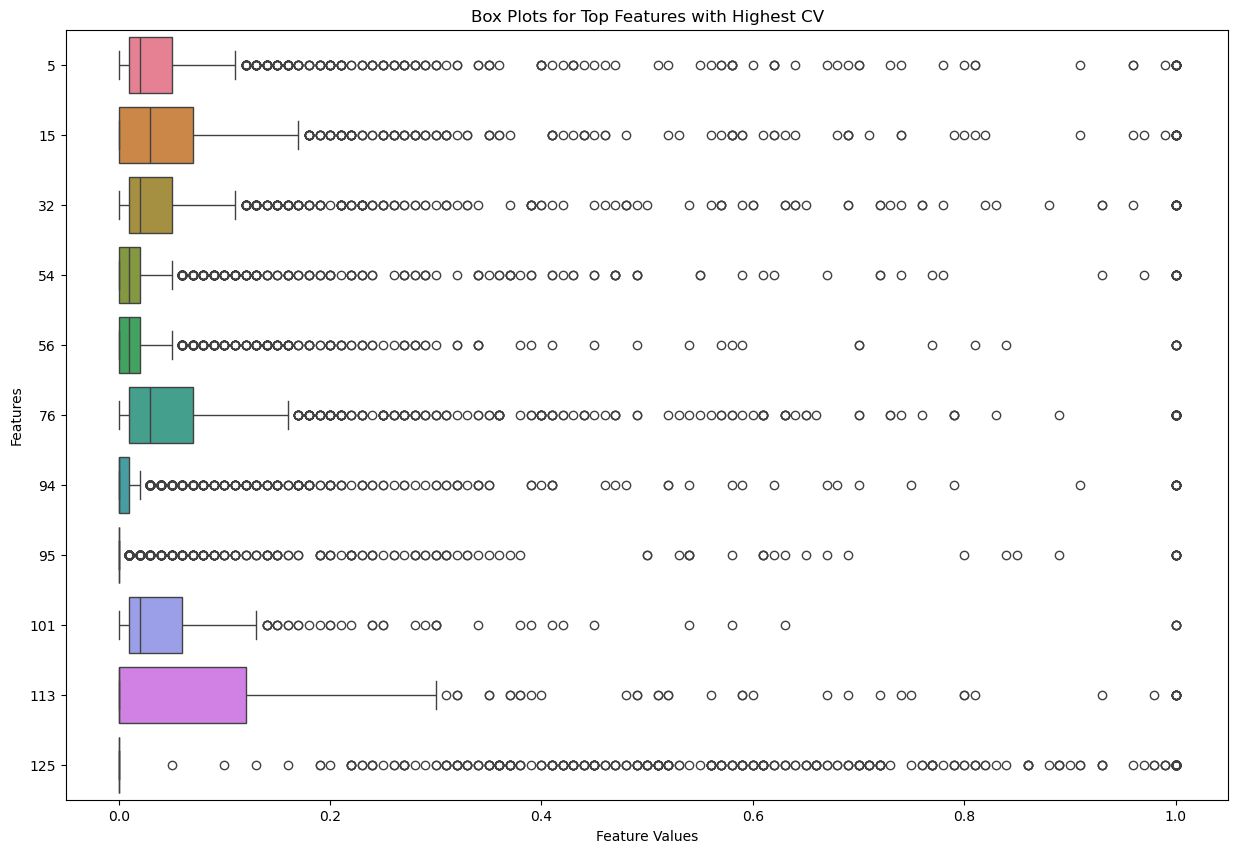

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=data_predictive[top_features], orient='h')  # Horizontal box plots
plt.title("Box Plots for Top Features with Highest CV")
plt.xlabel("Feature Values")
plt.ylabel("Features")
plt.show()

### Conclusion:
#### The scatterplots display a significant spread of data points, which makes it challenging to derive definitive conclusions from them alone. However, when paired with boxplots, particularly for larger datasets, they appear to provide meaningful insights.

### (f) Fit a linear model using least squares to the training set and report the test error.

In [ ]:
X_train = train_set_imputed.iloc[:, :-1]  
y_train = train_set_imputed.iloc[:, -1]   
X_test = test_set_imputed.iloc[:, :-1]
y_test = test_set_imputed.iloc[:, -1]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_error = mean_squared_error(y_test, y_pred)

print(f"Test Error (Mean Squared Error):", test_error)

Test Error (Mean Squared Error): 1.8099918341832492e+16


### (g) Fit a ridge regression model on the training set, with λchosen by cross-validation. Report the test error obtained.

In [ ]:
alphas = [0.1, 1.0, 10.0, 100.0, 200.0]  
ridge_cv = RidgeCV(alphas=alphas)
ridge_cv.fit(X_train, y_train)

chosen_alpha = ridge_cv.alpha_
print(f"Chosen Lambda (Alpha): {chosen_alpha}")

y_pred = ridge_cv.predict(X_test)

test_error = mean_squared_error(y_test, y_pred)
print(f"Test Error (Mean Squared Error):", test_error)

Chosen Lambda (Alpha): 1.0
Test Error (Mean Squared Error): 0.017732474992889713


### (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [ ]:
lasso_cv_no_std = LassoCV(cv=5, random_state=42, max_iter=10000).fit(X_train, y_train)

chosen_alpha_no_std = lasso_cv_no_std.alpha_

y_pred_no_std = lasso_cv_no_std.predict(X_test)

test_error_no_std = mean_squared_error(y_test, y_pred_no_std)

selected_features_no_std = X_train.columns[lasso_cv_no_std.coef_ != 0].tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv_std = LassoCV(cv=5, random_state=42, max_iter=10000).fit(X_train_scaled, y_train)

chosen_alpha_std = lasso_cv_std.alpha_

y_pred_std = lasso_cv_std.predict(X_test_scaled)

test_error_std = mean_squared_error(y_test, y_pred_std)

selected_features_std = X_train.columns[lasso_cv_std.coef_ != 0].tolist()

print(f"Without Standardization:")
print(f"Chosen Lambda (Alpha): {chosen_alpha_no_std}")
print(f"Test Error (Mean Squared Error): {test_error_no_std:}")
print(f"Selected Features: {selected_features_no_std}\n")

print(f"With Standardization:")
print(f"Chosen Lambda (Alpha): {chosen_alpha_std}")
print(f"Test Error (Mean Squared Error): {test_error_std:}")
print(f"Selected Features: {selected_features_std}")

Without Standardization:
Chosen Lambda (Alpha): 0.00011614723626829858
Test Error (Mean Squared Error): 0.017758209216319674
Selected Features: [7, 9, 11, 12, 16, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 33, 34, 38, 39, 41, 43, 44, 45, 49, 50, 51, 53, 54, 55, 56, 60, 64, 66, 68, 69, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 87, 90, 91, 92, 93, 94, 95, 96, 97, 99, 104, 105, 107, 109, 111, 113, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126]

With Standardization:
Chosen Lambda (Alpha): 0.0007630833878262516
Test Error (Mean Squared Error): 0.017805339276862273
Selected Features: [7, 9, 11, 12, 16, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 33, 34, 38, 39, 43, 44, 45, 49, 50, 51, 53, 54, 55, 56, 58, 60, 64, 66, 68, 69, 72, 73, 74, 76, 77, 79, 80, 81, 82, 83, 87, 90, 91, 92, 93, 94, 95, 96, 99, 104, 105, 107, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 123, 124]


### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

mse_scores = []
for m in range(1, X_train_pca.shape[1] + 1):  
    X_train_reduced = X_train_pca[:, :m]
    model = LinearRegression()
    mse = -np.mean(cross_val_score(model, X_train_reduced, y_train, cv=5, scoring='neg_mean_squared_error'))
    mse_scores.append(mse)

optimal_m = np.argmin(mse_scores) + 1  

X_train_optimal = X_train_pca[:, :optimal_m]
X_test_optimal = X_test_pca[:, :optimal_m]
model = LinearRegression()
model.fit(X_train_optimal, y_train)

y_pred = model.predict(X_test_optimal)
test_error = mean_squared_error(y_test, y_pred)

print("Optimal number of principal components (M):", optimal_m)
print("Test Error (Mean Squared Error):", test_error)

Optimal number of principal components (M): 96
Test Error (Mean Squared Error): 0.018471778516167735


### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine α (the regularization term) using cross-validation.

In [ ]:
xgb_model = XGBRegressor(objective='reg:squarederror', booster='gbtree', random_state=42)

param_grid = {'alpha': [0.1, 1, 10, 100]}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

test_error = mean_squared_error(y_test, y_pred)

print(f"Optimal Regularization Parameter (Alpha): {best_alpha}")
print(f"Test Error (Mean Squared Error):", test_error)

Optimal Regularization Parameter (Alpha): 1
Test Error (Mean Squared Error): 0.017747461401957192
